## 1. INTRODUCTION

Bulldozers are used in the construction sector for a variety of tasks including land clearing, dozing, handling scrap, and hauling other large construction equipment. In order to improve the quality of work, complete specific tasks with less human interference, and manage complex projects, a significant rate of adoption of technologically advanced equipment has been seen in the construction industry and this is expected to increase demand for dozers in the construction industry **[Reference](https://www.bulldozer.in/blog/bulldozing-market-future-scope-and-growth-factors/)**.

In this notebook, we will try to predict the sale price of bulldozer based on its usage, equipment type, and configuration.

<h4 style="background-color:#0b0504;color:white;border-radius: 8px; padding:12px">1.1. PROBLEM DEFINITION/GOAL</h4>

* Given that we are attempting to predict a number, the problem we are exploring is a regression problem.<br>
* Our goal is to forecast the future sale price of a bulldozer based on its features as well as the prices of similar bulldozers that have previously been sold.

<h4 style="background-color:#0b0504;color:white;border-radius: 8px; padding:12px">1.2. DATA SOURCE</h4>

The data was obtained from the **[Kaggle](https://www.kaggle.com/competitions/bluebook-for-bulldozers/data)** Bluebook for Bulldozers competition and it contains 3 main datasets:
* **Train.csv** (the training set), which contains data through the end of 2011. It includes thes `SalePrice`, which is the target variable.
* **Valid.csv** (the validation set), which contains data from January 1, 2012 - April 30, 2012. 
* **Test.csv** (the test set), which contains data from May 1, 2012 - November 2012. It does not contain the `SalePrice` attribute, since this is the what we'll try to predict.

<h4 style="background-color:#0b0504;color:white;border-radius: 8px; padding:12px">1.3. EVALUATION</h4>

The evaluation benchmark for this project is the [`RMSLE`](https://www.kaggle.com/competitions/bluebook-for-bulldozers/overview/evaluation) (root mean squared log error) between the actual and predicted auction prices. Our goal is to get the RMSLE value as low as possible.

<h4 style="background-color:#0b0504;color:white;border-radius: 8px; padding:12px">1.4. FEATURES</h4>

First Ten Features:
* **SalesID:** Unique identifier of a particular sale of a machine at auction
* **MachineID:** Identifier for a particular machine;  machines may have multiple sales
* **ModelID:** Identifier for a unique machine model (i.e. fiModelDesc)
* **Datasource:** Source of the sale record;  some sources are more diligent about reporting attributes of the machine than others.  Note that a particular datasource may report on multiple auctioneerIDs.
* **auctioneerID:** Identifier of a particular auctioneer, i.e. company that sold the machine at auction.  Not the same as datasource.
* **YearMade:** Year of manufacturer of the Machine
* **MachineHoursCurrentMeter:** Current usage of the machine in hours at time of sale (saledate);  null or 0 means no hours have been reported for that sale
* **UsageBand:** Value (low, medium, high) calculated comparing this particular Machine-Sale hours to average usage for the fiBaseModel;  e.g. 'Low' means this machine has less hours given it's lifespan relative to average of fiBaseModel.
* **Saledate:** Time of sale
* **Saleprice:** Cost of sale in USD

View complete Data Dictionary **[HERE](https://docs.google.com/spreadsheets/d/1vslmSkFUnyNdC177hA1MfIMk5gd_hZbEM1-OBlpubNY/edit?usp=sharing)**.

## 2. PROCESSING DATA FOR MODELING

<h4 style="background-color:#0b0504;color:white;border-radius: 8px; padding:12px">2.1. LOADING THE TOOLS</h4>

In [1]:
#ignoring warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

# Regular EDA and plotting libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Loading model
from sklearn.ensemble import RandomForestRegressor

# Loading model evaluators
from sklearn.metrics import mean_squared_log_error, mean_absolute_error
from sklearn.model_selection import RandomizedSearchCV

<h4 style="background-color:#0b0504;color:white;border-radius: 8px; padding:12px">2.2. PRELIMINARY ANALYSIS</h4>

In [3]:
df = pd.read_csv("../input/bluebook-for-bulldozers/TrainAndValid.csv", 
                 low_memory=False)
df.shape


(412698, 53)

In [4]:
df.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1139246,66000.0,999089,3157,121,3.0,2004,68.0,Low,11/16/2006 0:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
1,1139248,57000.0,117657,77,121,3.0,1996,4640.0,Low,3/26/2004 0:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1139249,10000.0,434808,7009,121,3.0,2001,2838.0,High,2/26/2004 0:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1139251,38500.0,1026470,332,121,3.0,2001,3486.0,High,5/19/2011 0:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1139253,11000.0,1057373,17311,121,3.0,2007,722.0,Medium,7/23/2009 0:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
df.tail()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
412693,6333344,10000.0,1919201,21435,149,2.0,2005,NaN,NaN,3/7/2012 0:00,...,None or Unspecified,None or Unspecified,None or Unspecified,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN
412694,6333345,10500.0,1882122,21436,149,2.0,2005,NaN,NaN,1/28/2012 0:00,...,None or Unspecified,None or Unspecified,None or Unspecified,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN
412695,6333347,12500.0,1944213,21435,149,2.0,2005,NaN,NaN,1/28/2012 0:00,...,None or Unspecified,None or Unspecified,None or Unspecified,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN
412696,6333348,10000.0,1794518,21435,149,2.0,2006,NaN,NaN,3/7/2012 0:00,...,None or Unspecified,None or Unspecified,None or Unspecified,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN
412697,6333349,13000.0,1944743,21436,149,2.0,2006,NaN,NaN,1/28/2012 0:00,...,None or Unspecified,None or Unspecified,None or Unspecified,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Data columns (total 53 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   SalesID                   412698 non-null  int64  
 1   SalePrice                 412698 non-null  float64
 2   MachineID                 412698 non-null  int64  
 3   ModelID                   412698 non-null  int64  
 4   datasource                412698 non-null  int64  
 5   auctioneerID              392562 non-null  float64
 6   YearMade                  412698 non-null  int64  
 7   MachineHoursCurrentMeter  147504 non-null  float64
 8   UsageBand                 73670 non-null   object 
 9   saledate                  412698 non-null  object 
 10  fiModelDesc               412698 non-null  object 
 11  fiBaseModel               412698 non-null  object 
 12  fiSecondaryDesc           271971 non-null  object 
 13  fiModelSeries             58667 non-null   o

In [7]:
df.isna().sum()

SalesID                          0
SalePrice                        0
MachineID                        0
ModelID                          0
datasource                       0
auctioneerID                 20136
YearMade                         0
MachineHoursCurrentMeter    265194
UsageBand                   339028
saledate                         0
fiModelDesc                      0
fiBaseModel                      0
fiSecondaryDesc             140727
fiModelSeries               354031
fiModelDescriptor           337882
ProductSize                 216605
fiProductClassDesc               0
state                            0
ProductGroup                     0
ProductGroupDesc                 0
Drive_System                305611
Enclosure                      334
Forks                       214983
Pad_Type                    331602
Ride_Control                259970
Stick                       331602
Transmission                224691
Turbocharged                331602
Blade_Extension     

In [8]:
df.describe()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter
count,4.126980e+05,412698.000000,4.126980e+05,412698.000000,412698.000000,392562.000000,412698.000000,1.475040e+05
mean,2.011161e+06,31215.181414,1.230061e+06,6947.201828,135.169361,6.585268,1899.049637,3.522988e+03
std,1.080068e+06,23141.743695,4.539533e+05,6280.824982,9.646749,17.158409,292.190243,2.716993e+04
min,1.139246e+06,4750.000000,0.000000e+00,28.000000,121.000000,0.000000,1000.000000,0.000000e+00
25%,1.421898e+06,14500.000000,1.088593e+06,3261.000000,132.000000,1.000000,1985.000000,0.000000e+00
50%,1.645852e+06,24000.000000,1.284397e+06,4605.000000,132.000000,2.000000,1995.000000,0.000000e+00
75%,2.261012e+06,40000.000000,1.478079e+06,8899.000000,136.000000,4.000000,2001.000000,3.209000e+03
max,6.333349e+06,142000.000000,2.486330e+06,37198.000000,173.000000,99.000000,2014.000000,2.483300e+06


**SUMMARY OF INITIAL FINDINGS**<br>
* There are `412,698` rows (entries), and `53` columns (features).<br>
* There are quite a lot of missing values which we'll have to fix later.<br>
* The `saledate` is in the object type. We'll have to format it into a datetime object to be able to work with it.<br>
* Most of our columns are in the string datatype. We would have to convert them into category datatype.

<h4 style="background-color:#0b0504;color:white;border-radius: 8px; padding:12px">2.3. DATA PREPROCESSING</h4>

**Preprocessing steps:**
* Fix the `saledate` column by converting it to a datetime type.<br>
* Create new columns from the `saledate` column to enrich our data.<br>
* Convert the strings in our data to numbers, and,<br>
* Fill up our missing values.

**PARSE DATES**<br>
To transform our `saledate` column into `datetime` data type, we will use the `parse_dates` parameter to turn it into real `datetime` type. So, we'll load the data again but this time, we'll parse dates.

In [9]:
df = pd.read_csv("../input/bluebook-for-bulldozers/TrainAndValid.csv", 
                 low_memory=False,
                 parse_dates=["saledate"])

In [10]:
# Let's confirm the changes

df.saledate.head(10)

0   2006-11-16
1   2004-03-26
2   2004-02-26
3   2011-05-19
4   2009-07-23
5   2008-12-18
6   2004-08-26
7   2005-11-17
8   2009-08-27
9   2007-08-09
Name: saledate, dtype: datetime64[ns]

Now we can see that saledate is now a datetime object. However, it's not in an ascending order. To do that, we'll sort our dataframe by saledate.

**SORT DATAFRAME BY `SALEDATE`**

In [11]:
df.sort_values(by=["saledate"], inplace=True, ascending=True)
df.saledate.head(10)

205615   1989-01-17
274835   1989-01-31
141296   1989-01-31
212552   1989-01-31
62755    1989-01-31
54653    1989-01-31
81383    1989-01-31
204924   1989-01-31
135376   1989-01-31
113390   1989-01-31
Name: saledate, dtype: datetime64[ns]

In [12]:
# Let's make a copy of our dataframe
# Incase we'll have need of it in the future

df_new = df.copy()
df_new.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
205615,1646770,9500.0,1126363,8434,132,18.0,1974,NaN,NaN,1989-01-17,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,Straight,None or Unspecified,NaN,NaN
274835,1821514,14000.0,1194089,10150,132,99.0,1980,NaN,NaN,1989-01-31,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
141296,1505138,50000.0,1473654,4139,132,99.0,1978,NaN,NaN,1989-01-31,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,Straight,None or Unspecified,NaN,NaN
212552,1671174,16000.0,1327630,8591,132,99.0,1980,NaN,NaN,1989-01-31,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
62755,1329056,22000.0,1336053,4089,132,99.0,1984,NaN,NaN,1989-01-31,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,PAT,Lever,NaN,NaN


**CREATE NEW COLUMNS**<br>
Next, let's create new columns: `saleyear`, `salemonth`, `saleday`, `saledayofweek`, and `saledayofyear` columns from the `saledate` column, to enrich our dataframe.

In [13]:
# New colums
df_new["saleyear"] = df_new.saledate.dt.year
df_new["salemonth"] = df_new.saledate.dt.month
df_new["saleday"] = df_new.saledate.dt.day
df_new["saledayofweek"] = df_new.saledate.dt.dayofweek
df_new["saledayofyear"] = df_new.saledate.dt.dayofyear

# Let's confirm the changes
df_new.head().T

,205615,274835,141296,212552,62755
SalesID,1646770,1821514,1505138,1671174,1329056
SalePrice,9500.0,14000.0,50000.0,16000.0,22000.0
MachineID,1126363,1194089,1473654,1327630,1336053
ModelID,8434,10150,4139,8591,4089
datasource,132,132,132,132,132
auctioneerID,18.0,99.0,99.0,99.0,99.0
YearMade,1974,1980,1978,1980,1984
MachineHoursCurrentMeter,NaN,NaN,NaN,NaN,NaN
UsageBand,NaN,NaN,NaN,NaN,NaN
saledate,1989-01-17 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00


In [14]:
# Drop saledate
df_new.drop("saledate", axis=1, inplace=True)

**CONVERT STRINGS TO CATEGORIES**<br>
Since strings are not ingestible by machine learning models, we need first convert them to `category` dtype and then to numerical values.

In [15]:
for label, content in df_new.items():
    if pd.api.types.is_string_dtype(content):
        df_new[label] = content.astype("category").cat.as_ordered()
        
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 412698 entries, 205615 to 409203
Data columns (total 57 columns):
 #   Column                    Non-Null Count   Dtype   
---  ------                    --------------   -----   
 0   SalesID                   412698 non-null  int64   
 1   SalePrice                 412698 non-null  float64 
 2   MachineID                 412698 non-null  int64   
 3   ModelID                   412698 non-null  int64   
 4   datasource                412698 non-null  int64   
 5   auctioneerID              392562 non-null  float64 
 6   YearMade                  412698 non-null  int64   
 7   MachineHoursCurrentMeter  147504 non-null  float64 
 8   UsageBand                 73670 non-null   category
 9   fiModelDesc               412698 non-null  category
 10  fiBaseModel               412698 non-null  category
 11  fiSecondaryDesc           271971 non-null  category
 12  fiModelSeries             58667 non-null   category
 13  fiModelDescriptor       

**FILL MISSING VALUES**<br>
Before we fill missing values, let's see which of our numeric values have missing data.

In [16]:
for label, content in df_new.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            print(label)

auctioneerID
MachineHoursCurrentMeter


2 numeric columns **`auctioneerID`** and **`MachineHoursCurrentMeter`** have missing values in them. Let's fill them up with the median.

In [17]:
for label, content in df_new.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            # fill missing values with median
            df_new[label] = content.fillna(content.median())

Let's check to see if there are still any missing numeric values

In [18]:
print("Missing values in auctioneerID:", 
      df_new.auctioneerID.isna().sum())
print("Missing values in MachineHoursCurrentMeter:", 
      df_new.MachineHoursCurrentMeter.isna().sum())

Missing values in auctioneerID: 0
Missing values in MachineHoursCurrentMeter: 0


Next, let's fill and turn our categorical variables to numbers. But we'll first check for columns that are not numeric first.

In [19]:
for label, content in df_new.items():
    if not pd.api.types.is_numeric_dtype(content):
        # Turn categories to numbers +1
        df_new[label] = pd.Categorical(content).codes+1

In [20]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 412698 entries, 205615 to 409203
Data columns (total 57 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   SalesID                   412698 non-null  int64  
 1   SalePrice                 412698 non-null  float64
 2   MachineID                 412698 non-null  int64  
 3   ModelID                   412698 non-null  int64  
 4   datasource                412698 non-null  int64  
 5   auctioneerID              412698 non-null  float64
 6   YearMade                  412698 non-null  int64  
 7   MachineHoursCurrentMeter  412698 non-null  float64
 8   UsageBand                 412698 non-null  int8   
 9   fiModelDesc               412698 non-null  int16  
 10  fiBaseModel               412698 non-null  int16  
 11  fiSecondaryDesc           412698 non-null  int16  
 12  fiModelSeries             412698 non-null  int8   
 13  fiModelDescriptor         412698 non-nu

## 3. MODELING
For this problem we will use the independent variables to try and predict the dependent variable, i.e the `SalePrice`. 

<h4 style="background-color:#0b0504;color:white;border-radius: 8px; padding:12px">3.1. CHOOSING OUR MODEL AND SPLITTING OUR DATA</h4>

In [21]:
model = RandomForestRegressor(n_jobs=-1,
                             random_state=42)
# Fit the model
model.fit(df_new.drop("SalePrice", axis=1), df_new["SalePrice"])

RandomForestRegressor(n_jobs=-1, random_state=42)

Now we're going to split our data into training and validation set.

**Training set:** Data through the end of 2011<br>
**Validation set:** Data from January 1, 2012 to April 30, 2012

In [22]:
# Split data into training and validation
df_val = df_new[df_new.saleyear == 2012]
df_train = df_new[df_new.saleyear != 2012]

# Check the length of both sets
len(df_val), len(df_train)

(11573, 401125)

Now we'll split our data into X and y:<br>
**X_train:** Our train set without the `SalePrice` column<br>
**y_train:** Our train set with only the `SalePrice` column<br>
**X_valid:** Our validation set without the `SalePrice` column<br>
**y_valid:** Our validation set with only the `SalePrice` column

In [23]:
# Split data into X and y
X_train, y_train = df_train.drop("SalePrice", axis=1), df_train.SalePrice
X_valid, y_valid = df_val.drop("SalePrice", axis=1), df_val.SalePrice

# Check the shape of our X and y variables
X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((401125, 56), (401125,), (11573, 56), (11573,))

Our evaluation metric for this competiton is the **`RMSLE`** (root mean squared log error). First we'll create the evaluation function.

In [24]:
# Create evaluation function (the competition uses Root Mean Square Log Error)
from sklearn.metrics import mean_squared_log_error, mean_absolute_error

def rmsle(y_test, y_preds):
    return np.sqrt(mean_squared_log_error(y_test, y_preds))

# Create function to evaluate our model
def show_scores(model):
    train_preds = model.predict(X_train)
    val_preds = model.predict(X_valid)
    scores = {"Training MAE": mean_absolute_error(y_train, train_preds),
              "Valid MAE": mean_absolute_error(y_valid, val_preds),
              "Training RMSLE": rmsle(y_train, train_preds),
              "Valid RMSLE": rmsle(y_valid, val_preds),
              "Training R^2": model.score(X_train, y_train),
              "Valid R^2": model.score(X_valid, y_valid)}
    return scores

In [25]:
# Let's change maximum samples to 30,000
model = RandomForestRegressor(n_jobs=-1,
                              max_samples=30000)

In [26]:
model.fit(X_train, y_train)

RandomForestRegressor(max_samples=30000, n_jobs=-1)

In [27]:
show_scores(model)

{'Training MAE': 4729.129137101902,
 'Valid MAE': 6552.140189233561,
 'Training RMSLE': 0.22379606320058879,
 'Valid RMSLE': 0.27051980775682893,
 'Training R^2': 0.8968692973098096,
 'Valid R^2': 0.8577418204072449}

<h4 style="background-color:#0b0504;color:white;border-radius: 8px; padding:12px">3.2. HYPERPARAMETER TUNING</h4>

Let's tune our hyperparameters with **`RandomizedSearchCV`** to see if we can improve our scores.

In [28]:
# RandomForestRegressor hyperparameters
rf_grid = {"n_estimators": np.arange(10, 100, 50),
          "max_depth": [None, 3, 5, 10],
           "min_samples_split": np.arange(2, 20, 2),
           "min_samples_leaf": np.arange(1, 20, 2),
            "max_features": [0.5, 1, "sqrt", "auto"],
           "max_samples": [20000]}

# Tuning our model with RandomizedSearchCV
rs_rf = RandomizedSearchCV(RandomForestRegressor(),
                           param_distributions=rf_grid,
                           cv=5,
                           n_iter=20,
                           verbose=True)

# Fitting our X_train and y_train
rs_rf.fit(X_train, y_train);

Fitting 5 folds for each of 20 candidates, totalling 100 fits


In [29]:
rs_rf.best_params_

{'n_estimators': 10,
 'min_samples_split': 16,
 'min_samples_leaf': 5,
 'max_samples': 20000,
 'max_features': 'auto',
 'max_depth': 10}

In [30]:
show_scores(rs_rf)

{'Training MAE': 6554.614096703512,
 'Valid MAE': 7891.643455116154,
 'Training RMSLE': 0.29423428910983046,
 'Valid RMSLE': 0.31680755143266714,
 'Training R^2': 0.8131889477613438,
 'Valid R^2': 0.7929443545362431}

Now, let's train our model with the **best parameters** we found.

In [31]:
# Best hyperparameters
best_rf = RandomForestRegressor(n_estimators=60,
                                    min_samples_leaf=13,
                                    min_samples_split=12,
                                    max_features='auto',
                                    n_jobs=-1,
                                    max_samples=None)
best_rf.fit(X_train, y_train)

RandomForestRegressor(min_samples_leaf=13, min_samples_split=12,
                      n_estimators=60, n_jobs=-1)

In [32]:
show_scores(best_rf)

{'Training MAE': 3978.186614390701,
 'Valid MAE': 6184.291761947694,
 'Training RMSLE': 0.19052858137106904,
 'Valid RMSLE': 0.2534297309560438,
 'Training R^2': 0.9230451561208436,
 'Valid R^2': 0.8669137929561664}

Here we can see a huge improvement in our model performance.

<h4 style="background-color:#0b0504;color:white;border-radius: 8px; padding:12px">3.3. MAKING PREDICTIONS ON THE TEST DATA</h4>

Now it's time to make predictions on the test data. But before we do, we need to make the same changes we made to the train set on the test set.

In [33]:
# Import test_data
# Parse date
df_test = pd.read_csv("../input/bluebook-for-bulldozers/Test.csv", 
                      parse_dates=["saledate"])
df_test.head().T

,0,1,2,3,4
SalesID,1227829,1227844,1227847,1227848,1227863
MachineID,1006309,1022817,1031560,56204,1053887
ModelID,3168,7271,22805,1269,22312
datasource,121,121,121,121,121
auctioneerID,3,3,3,3,3
YearMade,1999,1000,2004,2006,2005
MachineHoursCurrentMeter,3688.0,28555.0,6038.0,8940.0,2286.0
UsageBand,Low,High,Medium,High,Low
saledate,2012-05-03 00:00:00,2012-05-10 00:00:00,2012-05-10 00:00:00,2012-05-10 00:00:00,2012-05-10 00:00:00
fiModelDesc,580G,936,EC210BLC,330CL,650K


Now we'll create a function that will effect all the changes at once.

In [34]:
def preprocess_data(df_new):
    # Add datetime parameters for saledate
    df_new["saleyear"] = df_new.saledate.dt.year
    df_new["salemonth"] = df_new.saledate.dt.month
    df_new["saleday"] = df_new.saledate.dt.day
    df_new["saledayofweek"] = df_new.saledate.dt.dayofweek
    df_new["saledayofyear"] = df_new.saledate.dt.dayofyear

    # Drop saledate
    df_new.drop("saledate", axis=1, inplace=True)
    
    # Fill numeric rows with the median
    for label, content in df_new.items():
        if pd.api.types.is_numeric_dtype(content):
            if pd.isnull(content).sum():
                
                # fill missing values with median
                df_new[label] = content.fillna(content.median())
                
        # Turn categorical variables into numbers
        for label, content in df_new.items():
            if not pd.api.types.is_numeric_dtype(content):
                # Turn categories to numbers +1
                df_new[label] = pd.Categorical(content).codes+1       
    
    return df_new

In [35]:
df_test = preprocess_data(df_test)
df_test.head().T

,0,1,2,3,4
SalesID,1227829.0,1227844.0,1227847.0,1227848.0,1227863.0
MachineID,1006309.0,1022817.0,1031560.0,56204.0,1053887.0
ModelID,3168.0,7271.0,22805.0,1269.0,22312.0
datasource,121.0,121.0,121.0,121.0,121.0
auctioneerID,3.0,3.0,3.0,3.0,3.0
YearMade,1999.0,1000.0,2004.0,2006.0,2005.0
MachineHoursCurrentMeter,3688.0,28555.0,6038.0,8940.0,2286.0
UsageBand,2.0,1.0,3.0,1.0,2.0
fiModelDesc,499.0,831.0,1177.0,287.0,566.0
fiBaseModel,180.0,292.0,404.0,113.0,196.0


In [36]:
print("Test Dataset has",df_test.isnull().values.sum(), "missing values")

Test Dataset has 0 missing values


In [37]:
test_preds = best_rf.predict(df_test)

In [38]:
# Create DataFrame

df_preds = pd.DataFrame()
df_preds["SalesID"] = df_test["SalesID"]
df_preds["SalePrice"] = test_preds
df_preds

,SalesID,SalePrice
0,1227829,20955.530619
1,1227844,16488.405307
2,1227847,49053.815878
3,1227848,87592.505447
4,1227863,45213.012546
...,...,...
12452,6643171,55081.075286
12453,6643173,10927.848094
12454,6643184,12807.866872
12455,6643186,16547.458324


<h4 style="background-color:#0b0504;color:white;border-radius: 8px; padding:12px">3.4. FEATURE IMPORTANCE</h4>

Let's see which independent variable contributed the most to the prediction we got from the random forest regression model. This will give us better interpretability of the data.

In [39]:
best_rf.feature_importances_

array([4.39357428e-02, 8.46445687e-03, 3.05042565e-02, 7.85640604e-05,
       1.45409177e-03, 2.83127440e-01, 1.32125391e-03, 5.25402663e-04,
       1.81417749e-02, 8.46855888e-02, 5.48442420e-02, 4.32084466e-03,
       3.56498106e-03, 2.51562422e-01, 4.26116942e-02, 3.12611984e-03,
       1.77637410e-04, 9.39487488e-05, 1.80505811e-03, 8.80225960e-03,
       9.71581922e-05, 1.14574709e-05, 3.21500078e-04, 1.50656906e-04,
       1.35981082e-03, 3.44268253e-06, 8.30017715e-04, 6.00036808e-03,
       6.06661993e-04, 2.81968058e-04, 5.21666028e-03, 4.24660444e-03,
       1.68602535e-03, 4.54907014e-03, 9.42675931e-04, 1.47121132e-03,
       4.64380978e-04, 3.29063064e-02, 3.15080190e-06, 1.51726385e-06,
       1.26967240e-04, 6.06079878e-04, 6.40232929e-04, 4.07257777e-04,
       1.19176151e-04, 9.31788500e-05, 3.02307633e-04, 9.56028229e-04,
       8.19972854e-04, 1.23501710e-04, 2.19619297e-04, 7.83047276e-02,
       9.37425439e-04, 2.55014708e-03, 1.15590683e-03, 8.33904630e-03])

In [40]:
# Function for plotting feature importance
def plot_features(columns, importances, n=30):
    df = (pd.DataFrame({"features": columns,
                        "feature_importances": importances})
          .sort_values("feature_importances", ascending=False)
          .reset_index(drop=True))
    
    # Plot the dataframe
    fig, ax = plt.subplots(figsize=(8,10))
    ax.barh(df["features"][:n], df["feature_importances"][:30], 
            color='#44443d')
    ax.set_ylabel(None)
    ax.set_xlabel("Feature importance")
    ax.invert_yaxis()

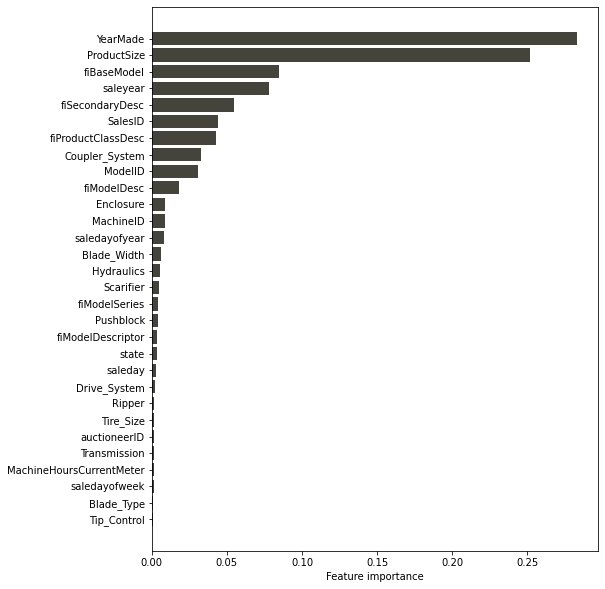

In [41]:
plot_features(X_train.columns, best_rf.feature_importances_)

Here we can see that the features that contributed the most to the prediction we got from the RandomForestRegressor in order of importance are: `YearMade`, `ProductSize`, `saleYear`, `Enclosure`, `fiSecondaryDesc`, etc. Features like the `Blade_Type`, `Engine_Horsepower`, `saledayofweek`, `Transmission`, etc., only contributed but a little.

You're welcome to try other models and adjust the hyperparameters for better result. 

I hope you found this helpful? If **YES**, please consider leaving an upvote. Thanks for reading!